# Clustering and plotting of snATAC-seq signal  

Author: Daniel Levings  
Date: 2022-06-29  

This is the first of two **Jupyter Notebooks** created to document my comparison of a mouse brain snATAC-seq (single nuclei assay for transposase accessible chromatin with sequencing) data set from 
[CATlas](http://catlas.org/mousebrain/) with a scRNA-seq (single cell RNA sequencing) data set from the Linnarsson lab's [Mouse brain atlas](http://mousebrain.org/).  Specifically, in this code, I identify differences in neuronal vs other cell types in the mouse brain based on both chromatin accessbility (snATAC-seq signal aggregated by cell type/cluster).  

Datasets accompany the following papers:  

[Li, Y.E., Preissl, S., Hou, X. et al. An atlas of gene regulatory elements in adult mouse](https://doi.org/10.1038/s41586-021-03604-1)  
[cerebrum. (2021). *Nature* 598, 129–136. https://doi.org/10.1038/s41586-021-03604-1](https://doi.org/10.1038/s41586-021-03604-1)  

[La Manno, G., Siletti, K., Furlan, A., et al. Molecular architecture of the developing](https://doi.org/10.1038/s41586-021-03775-x)  
[mouse brain. Nature. 2021 Aug;596(7870):92-96. Epub 2021 Jul 28.](https://doi.org/10.1038/s41586-021-03775-x])  
[https://doi.org/10.1038/s41586-021-03775-x](https://doi.org/10.1038/s41586-021-03775-x])  

<br>

## Set up environment  

First import relevant *Python* modules.  If not installed, please install the following with *pip* or *conda*:  

- *numpy*  
- *pandas*  
- *scipy*  
- *pyBigWig*  
- *matplotlib*  
- *seaborn*  

In [1]:
# Set up environment
import os
import sys
import re
import itertools
from datetime import date
import numpy as np
import pandas as pd
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
from scipy.cluster import hierarchy
import statistics
import loompy
import pyBigWig
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

<br>

Now check the currently loaded environment:  

In [2]:
print(sys.version_info)
modulenames = set(sys.modules) & set(globals())
print(modulenames)
del(modulenames)

sys.version_info(major=3, minor=9, micro=13, releaselevel='final', serial=0)
{'os', 'pyBigWig', 'sys', 're', 'loompy', 'builtins', 'itertools', 'statistics'}


<br>

## Set up data import  

Initialize some lists for storing bigwig names and location/path and then 'scan' the bigwig directory using *regex* and save the names and paths to these lists:  

In [3]:
# Initialize lists
bigwig_paths = []
bigwig_names = []
bigwig_dir = os.getcwd() + "/bigwigs/"

# Scan directory using regex and save to lists
regex_ATAC = re.compile("(.*)\.bw")
for root, dirs, files in os.walk(bigwig_dir):
    for file in files:
        if regex_ATAC.match(file):
            bigwig_paths.append(str(bigwig_dir+file))
            name = regex_ATAC.search(file)
            bigwig_names.append(name.group(1))

<br>

Check the lists to make sure they contain the relevant info:  

In [4]:
bigwig_paths[0:6]

['/home/daniel/Desktop/mouse-brain/bigwigs/CA3GL1.bw',
 '/home/daniel/Desktop/mouse-brain/bigwigs/SSTGA7.bw',
 '/home/daniel/Desktop/mouse-brain/bigwigs/PTGL5.bw',
 '/home/daniel/Desktop/mouse-brain/bigwigs/CTGL2.bw',
 '/home/daniel/Desktop/mouse-brain/bigwigs/VIPGA1.bw',
 '/home/daniel/Desktop/mouse-brain/bigwigs/OBGL2.bw']

In [5]:
bigwig_names[0:6]

['CA3GL1', 'SSTGA7', 'PTGL5', 'CTGL2', 'VIPGA1', 'OBGL2']

In [6]:
len(bigwig_paths)

160

<br>

## Read in and process data  

Define a function named *bigwig_matrix* that will both: 1) import the bigwigs using *pyBigWig*, and 2) split or *tile* the signal data into a certain number of bins for a region of interest.  Specifically, each bin of *n* width is summarized by either getting the *coverage*, *average*, *min*, or *max* signal over the bin using the *stats* function from *pyBigWig*.  

For this function, the user needs to provide: a list of paths to the bigwigs of interest (*bw_list*), the region of interest (*chrom* = chromosome, *start* = starting base of the region, *end* = ending base of the region), the type of summarization (*avgtype* = see [*pyBigWig* documentation](https://github.com/deeptools/pyBigWig)), the total number of windows/*tiles* the region should be split into (*nBins*) and optionally the names of the bigwigs (*bw_names*) if you don't want the file names used.  

In [7]:
def compute_matrix(bw_list, chrom = None, start = None, end = None, avgtype = "max", nBins = 1080, bw_names = None):
    new_bw_names=[]
    bw_results=[]
    for i in range(0,len(bw_list)):
        # i=0
        bw_name=re.sub("\.(bigwig)|(bw)|(bigWig)]$", "", str(bw_list[i]))
        bw_name=re.sub(".*\/","",bw_name)
        new_bw_names.append(bw_name)
        bw = pyBigWig.open(bw_list[i])
        if not bw.isBigWig():
            raise BigwigValidError(str(bw_list[i] + " is not a valid bigwig file."))
        bw_results.append(bw.stats(chrom, start = start, end = end, type = avgtype, nBins = nBins, exact = True))
    if bw_names is None:
        bw_names=new_bw_names
    bw_df = pd.DataFrame(bw_results)
    bw_df.index = bw_names
    return(bw_df)

class BigwigValidError(Exception):
    pass

def bigwig_matrix(bw_list, chrom, start, end, avgtype = "max", nBins = 1080, bw_names = None):
    try:
        final_mat = compute_matrix(bw_list = bw_list, chrom = chrom, start = start, end = end, avgtype = avgtype, nBins = nBins, bw_names = bw_names)
    except BigwigValidError as e:
        print(str(e))
    return(final_mat)

<br>

Use this newly created function to compute the *binned/tiled* signal over the region of interest for all bigwigs, with each bigwig as its own row:

In [8]:
snATACseq_bw_matrix = bigwig_matrix(bw_list = bigwig_paths, chrom = "chr2", start=75650000, end=75725000, nBins=2560, bw_names = bigwig_names)

<br>

Now summarize to get the 99% percentile signal of each bin (column) across all rows (bigwigs).  

In [9]:
snATACseq_summ = pd.DataFrame({"x" : range(0, 2560), "signal_max" : snATACseq_bw_matrix.quantile(q = 0.99, axis=0)})

<br>

Now I create a dataframe to isolate a sub-range of the columns to cluster on (I don't want to cluster using the entire region because a control region is included on the far left side):  

In [13]:
full_region = range(75650000,75725000)
region_ind=[]
region_seq=[]
i=0
for number in full_region:
    if number % 29 == 0:
        region_ind.append(i)
        i += 1
        region_seq.append(number)

In [19]:
tmp=pd.DataFrame([region_ind, region_seq]).T
tmp.loc[tmp[1] > 75675490, :].head()

,0,1
879,879,75675500
880,880,75675529
881,881,75675558
882,882,75675587
883,883,75675616


In [20]:
tmp.loc[tmp[1] < 75709641, :].tail()


,0,1
2052,2052,75709517
2053,2053,75709546
2054,2054,75709575
2055,2055,75709604
2056,2056,75709633


In [21]:
del(tmp)

<br>

## Cluster the genomic signal  

Specify the subregion by using the column numbers (879 to 2057) corresponding to the genomic start and end coordinates of interest.  Now hierarchically cluster using this subregion.  

In [22]:
subregion_linkage = hc.linkage(snATACseq_bw_matrix.loc[:,879:2057], metric = "euclidean", method = "complete")

Also, convert to optimal leaf ordering (I prefer this aesthetically).  

In [23]:
subregion_linkage = hc.optimal_leaf_ordering(Z = subregion_linkage, y = snATACseq_bw_matrix.loc[:,879:2057])

Finally, do a *quick* plot of this region and the clustering using *Seaborn*.

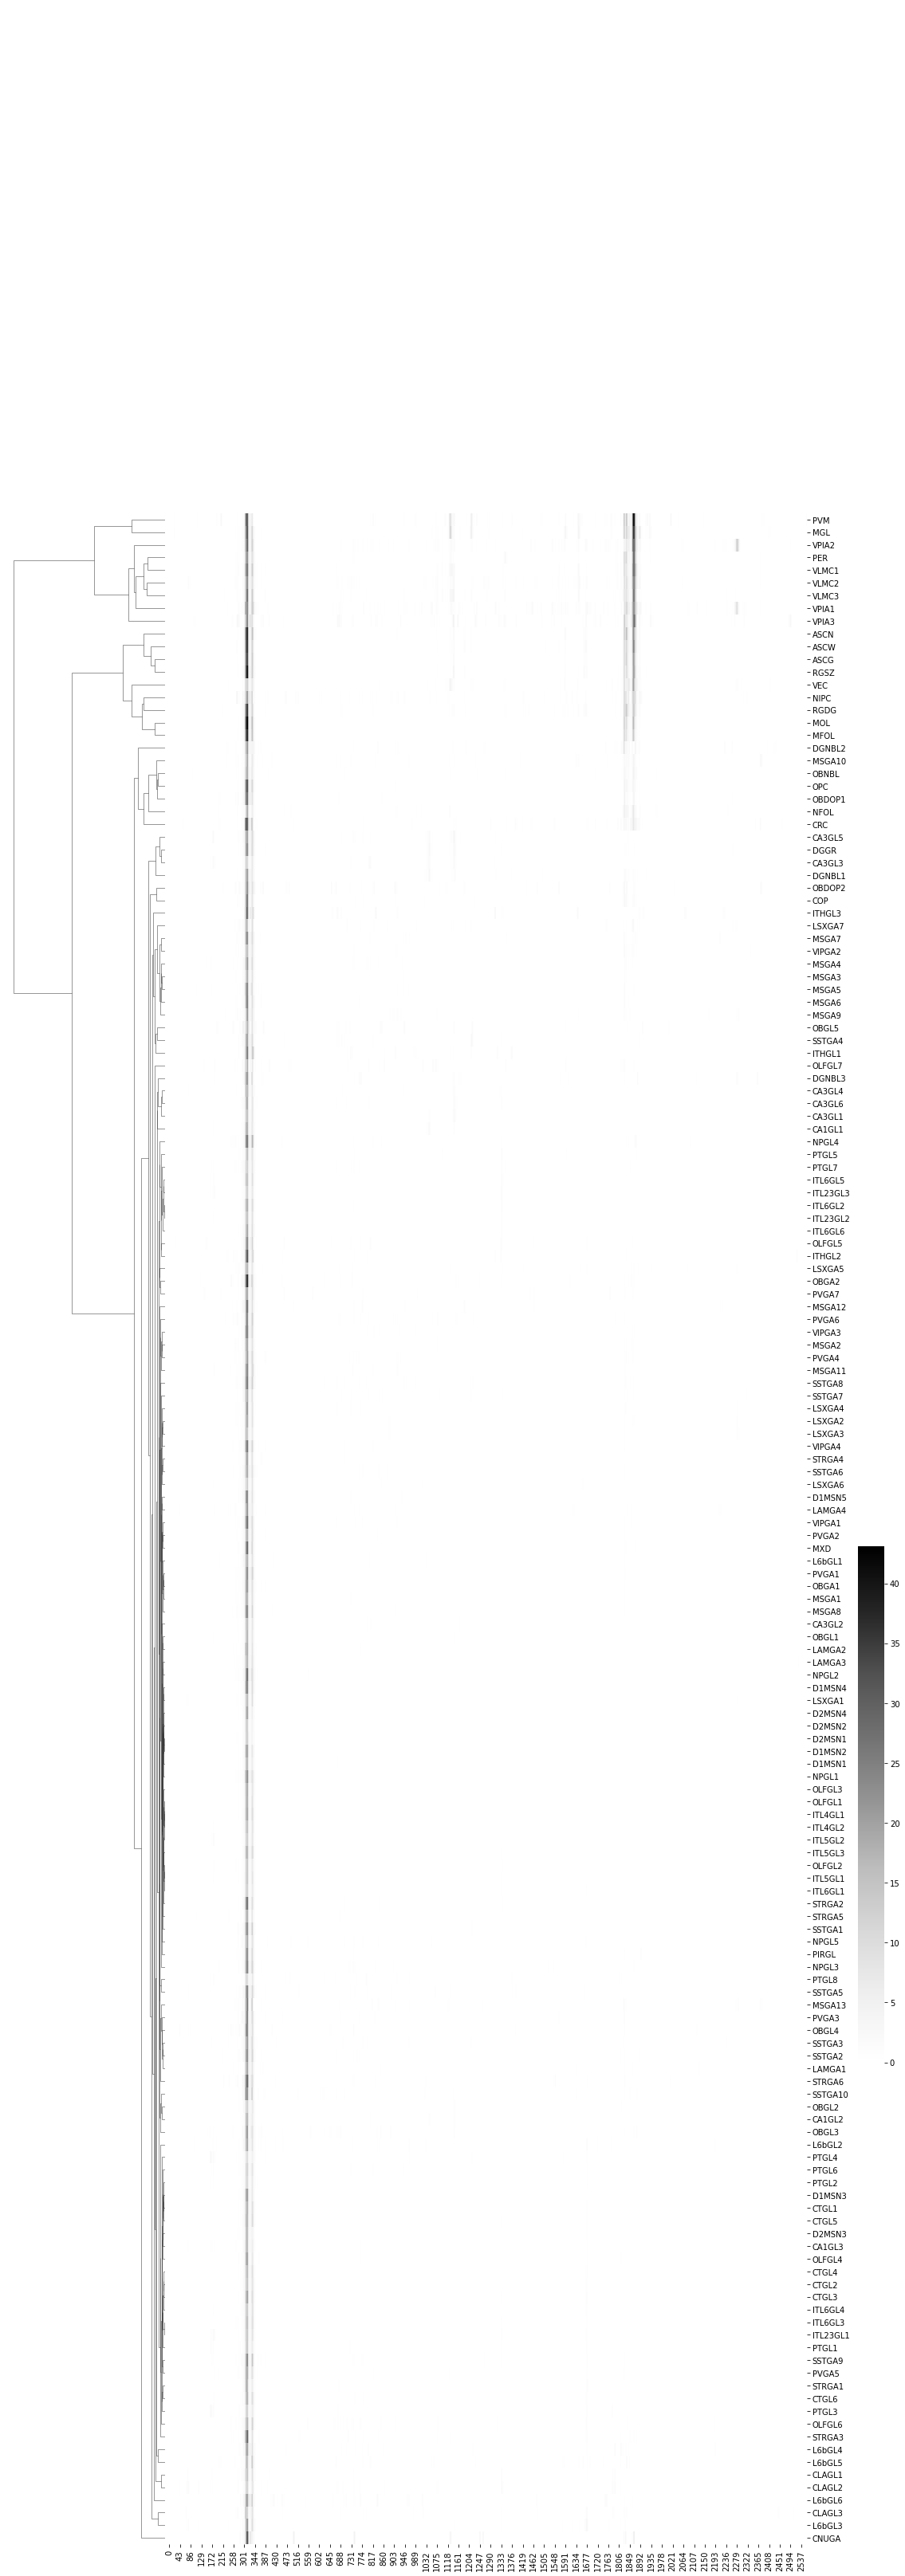

In [24]:
ax = sns.clustermap(snATACseq_bw_matrix, row_cluster = True, row_linkage = subregion_linkage, col_cluster = False,
    figsize=(15, 45), cbar_pos = (1,0.2, 0.03, 0.2), cmap = "Greys")
plt.show()

<br>

## Make customized plot with *matplotlib*

Now, use the 'standard' plotting library *matplotlib* to 'accessorize' the plot... specifically, adding a line plot of the 99th percentile signal above the plot, as well as the types of cells the rows correspond to on the right of the plot.  

First, read in a portion of Supplemental Table 3 from [Li, Y.E., et al. 2021. *Nature*.](https://doi.org/10.1038/s41586-021-03604-1) that will be used for annotating the basic cell types of each row.  

In [25]:
cell_attr = pd.read_excel("Cell annotation.xlsx")

Reassign the 'Class' attribute to a categorical variable class (for plotting).  

In [26]:
cell_class_df = cell_attr[['Class', 'Sub types']]
cell_class_df['Class'] = pd.Categorical(cell_class_df['Class'])
cell_class_df['Class_num'] = pd.Categorical(cell_class_df['Class']).codes

/tmp/ipykernel_20973/1996492540.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_class_df['Class'] = pd.Categorical(cell_class_df['Class'])


<br>

Now, plot the profile of 99th percentile signal, heatmap of signal across bigwigs, dendrogram of cell clustering, and basic cell types all together using *matplotlib*.  

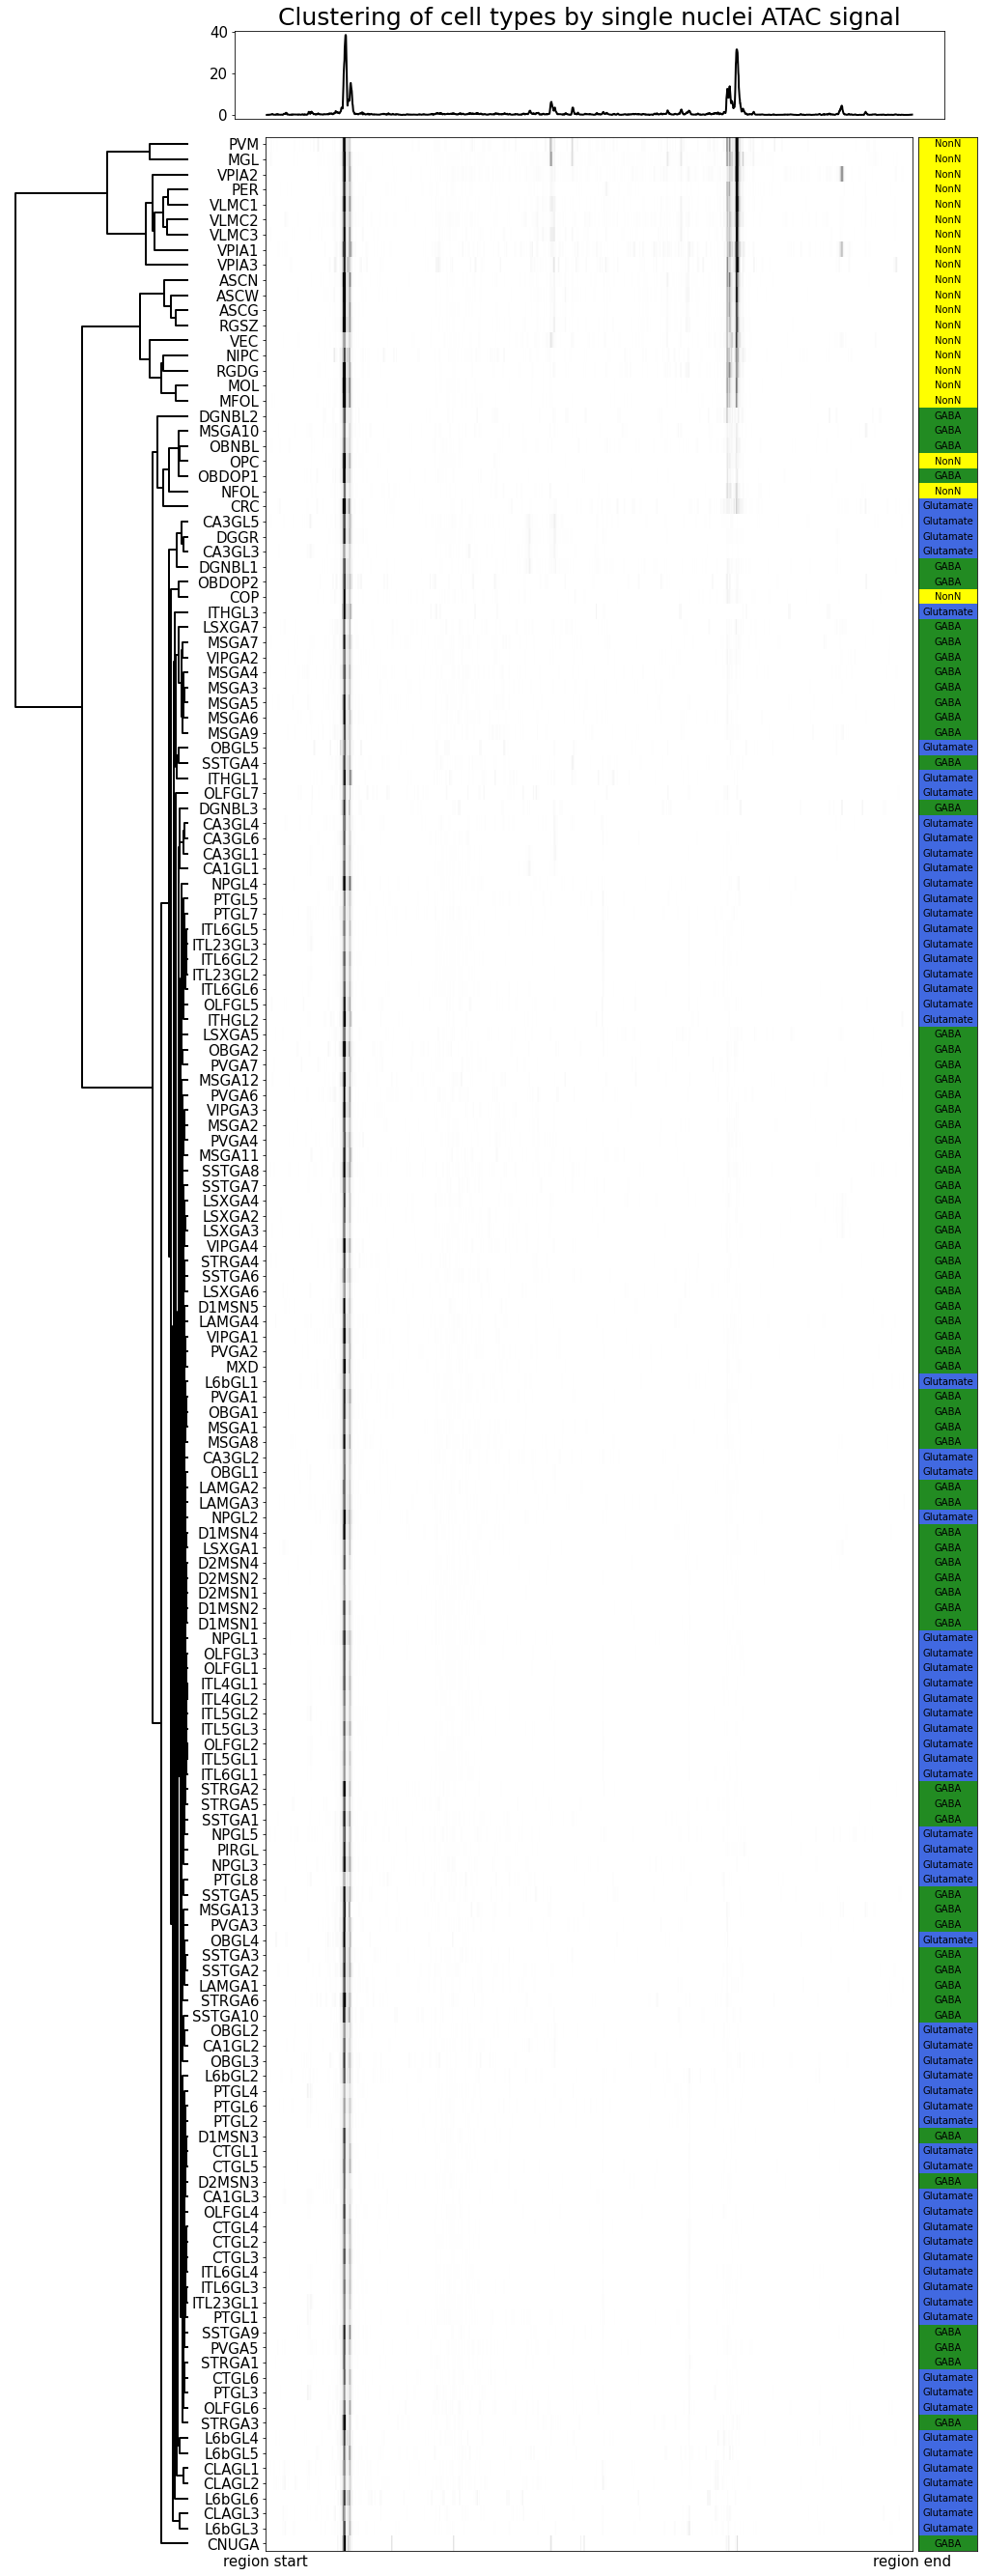

In [27]:
# Customize some plotting parameters
mpl.rcParams["axes.titlesize"] = 25
mpl.rcParams["axes.labelsize"] = 20
mpl.rcParams["xtick.labelsize"] = 15
mpl.rcParams["ytick.labelsize"] = 15
mpl.rcParams["legend.fontsize"] = 15
mpl.rcParams["figure.figsize"] = (18, 45)
mpl.rcParams["image.cmap"] = "Greys"
mpl.rcParams["lines.markersize"] = 3
mpl.rcParams["lines.linewidth"] = 2

# Check size of matrix for pltting heatmap
snATACseq_bw_matrix.shape

# Assign column names, only keep start and end point names, make all else blank
feature_names = list(itertools.chain.from_iterable(itertools.repeat(x,1) if isinstance(x,str) 
    else x for x in ["region start", list(itertools.repeat('', 2558)), "region end"]))

# Assign row names (cell type clusters)
labels = bigwig_names

# Make the data pandas objects
data = pd.DataFrame(np.array(snATACseq_bw_matrix), columns=feature_names, index = labels)
labels = pd.Series(labels)

# Row-cluster the data
row_link = hierarchy.linkage(snATACseq_bw_matrix.loc[:,879:2057], metric = "euclidean", method = "complete")
row_link = hierarchy.optimal_leaf_ordering(Z = row_link, y = snATACseq_bw_matrix.loc[:,879:2057])

# Make the dendrogram, but don't plot it yet
row_dendro = hierarchy.dendrogram(row_link, no_plot=True)

# Don't invert row order
row_order = row_dendro["leaves"]
# Row order needs to be inverted to display correctly with the dendrogram
# row_order = row_dendro["leaves"][::-1]
# Get max signal of matrix
np.matrix(snATACseq_bw_matrix).max()

# Reorder dataframe and row labels
data = data.iloc[row_order,:]
labels = labels[row_order]

# Make the heatmap and line plot above
fig = plt.figure(figsize = (18, 48))
ax = plt.subplot2grid(shape = (24, 30), loc = (1, 0), rowspan = 27, colspan = 30) 
ax2 = plt.subplot2grid(shape = (24, 30), loc = (0, 7), rowspan = 1, colspan = 22) 
profile = ax2.plot(snATACseq_summ['x'], snATACseq_summ['signal_max'], color = "black")
ax2.set_xticks([])
heatmap = ax.imshow(data, origin="upper", interpolation = "none", aspect="auto", vmin = 0, vmax = 25)

# Show the feature names on the x ticks and cluster name on y ticks and
# set custom tick sizes
ax.xaxis.set_tick_params(which = 'both', length = 0)
ax.yaxis.set_tick_params(which = 'major', length = 3)
ax.set_yticks(np.arange(data.index.size))
ax.set_xticks(np.arange(data.columns.size))
ax.set_xticklabels(data.columns)
ax.set_yticklabels(data.index)

# Make it so different annotations can be assigned to different sides/axes
divider = make_axes_locatable(ax)

# Add dendrogram for row clustering
row_ax = divider.append_axes("left", size="28%", pad = "12%")
hierarchy.dendrogram(row_link, orientation="left", ax=row_ax, color_threshold=0, above_threshold_color="black")
row_ax.invert_yaxis()
row_ax.axis("off")

# Combine data names and class attributes to reorder class heatmap
class_mat = pd.DataFrame({'Sub types' : np.array(data.index)}).merge(cell_class_df)

# Add bar/heatmap indicating classes to the right
class_ax = divider.append_axes("right", size="9%",pad = "1%")

# Use a different color scheme for this axis
cmp = mpl.colors.ListedColormap(['forestgreen', 'royalblue', 'yellow'])
class_ax.imshow(np.array(class_mat['Class_num'])[:,None], aspect="auto", cmap=cmp)
# Loop over data dimensions and create text annotations.

for i in range(160):
    text = class_ax.text(0, i, np.array(class_mat['Class'])[:,None][i, 0],
        ha="center", va="center", color="black")

del(i)
class_ax.set_xticks([])
class_ax.set_yticks([])

# Set title
ax2.set_title("Clustering of cell types by single nuclei ATAC signal")

# Plot to file or output to notebook
# plt.savefig("snATACseq-cluster-heatmap_Matplotlib.pdf")
plt.show()